In [10]:
from extractFeatures import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore",FutureWarning)

'''
k-means clustering

The elbow and intercluster functions are adapted from Yellowbrick's documentation: 
    https://www.scikit-yb.org/en/latest/index.html
    
PCA visualization code is adapted from this source: 
    https://www.askpython.com/python/examples/plot-k-means-clusters-python
'''
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('ggplot')


def elbow(df):
    from yellowbrick.cluster.elbow import kelbow_visualizer
    kelbow_visualizer(KMeans(), df, k=(2, 10),timings=False)
    # kelbow_visualizer(KMeans(), df, k=(2, 10),metric='calinski_harabasz',timings=False)
    # kelbow_visualizer(KMeans(), df, k=(2, 10),metric='silhouette',timings=False)
    
def intercluster(model,num):
    from yellowbrick.cluster import intercluster_distance
    intercluster_distance(KMeans(num),model, embedding='mds') 

def pca_cluster(df,num, tcpIDs,t):
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df) 
    model = KMeans(n_clusters=num) 
    label = model.fit_predict(pca_results) 
    kmeans_groups = defaultdict(list)
    for k,v in zip(label,tcpIDs):
        kmeans_groups[k].append(v)
    groupColors = {0:'pink',1:'purple',2:'darkblue',3:'plum',4:'palevioletred',5:'darkgreen'}
    u_labels = np.unique(label)
    for i in u_labels:
        plt.scatter(pca_results[label == i , 0] , pca_results[label == i , 1] , label = i,color=groupColors[i])
    plt.legend()
    plt.title(t,fontsize = 10)
    plt.figure(figsize=(20,10))
    plt.show()

    return kmeans_groups

TFIDF vectorization and clustering of the cleaned texts in the Charity Sermons dataset

In [ ]:
textInfo = getTexts('/Users/amycweng/Digital Humanities/charityTXT',tcpIDs,True)
print(len(textInfo))
vector = TfidfVectorizer(norm=None, sublinear_tf=True)
tfidf_texts = vector.fit_transform(textInfo.values())
df = pd.DataFrame(tfidf_texts.toarray(), index=textInfo.keys(), columns=vector.get_feature_names()) 

In [ ]:
'''Clustering based only on the original texts (no other features)'''
elbow(df)

In [ ]:
intercluster(df,3)
groups = pca_cluster(df,3,tcpIDs)

In [ ]:
for groupNum, ids_list in groups.items(): 
    if len(ids_list) == 1:
        print(f'There is {len(ids_list)} text in Group {groupNum}')
    else: 
        print(f'There are {len(ids_list)} texts in Group {groupNum}')
    if groupNum != 0: 
        print(f'\tTitles: {find_titles(ids_list),idToTitle}')
        print(f'\tGroup {groupNum} TCP IDs: {ids_list}')
    print(f'\tThe locations for the texts in this cluster: {count_features(location,ids_list)}')
    print(f'\tThe audiences for the texts in this cluster: {count_features(audience,ids_list)}')
    print(f'\tWhether or not the text mentions the provision of material help to the needy: {count_features(help_poor,ids_list)}')
    print(f'\tTop 20 TFIDF terms for the texts within this cluster: {Counter(top_terms(ids_list,textInfo.keys(),tfidf_texts,vector)).most_common(n=20)}')

    print(f'\tTop 20 Bigrams and Trigrams of Keywords: {count_features(ngrams,ids_list)}')
    print(f'\tTop 20 Topic Words: {count_features(topics,ids_list)}')
    print(f'\tAll subject headings: {count_features(subjects,ids_list)}')

    print(f'\tTop 20 Biblical/Apocryphal Citations: {count_features(all_citations,ids_list,"all citations")}')
    print(f'\tTop 20 Biblical/Apocryphal Citations Relating to Charity: {count_features(charity_citations,ids_list,"charity citations")}.\n\n')

In [72]:
'''Comparison of the performance of the TFIDF Transformer + Count Vectorizer vs. only the TfidfVectorizer'''
tcpID = 'A55754'
single_text_df = pd.DataFrame(tfidf_texts[[_ for _ in textInfo.keys()].index(tcpID)].T.todense(), index=vector.get_feature_names(), columns=[tcpID])
single_text_df = single_text_df.sort_values(tcpID, ascending=False)
top_tfidf = list(single_text_df.head(25).T.columns)
print(f'Method A (sublinear TF & no normalization): ', top_tfidf)

vector = TfidfVectorizer()
tfidf_results = vector.fit_transform(textInfo.values())
single_text_df = pd.DataFrame(tfidf_texts[[_ for _ in textInfo.keys()].index(tcpID)].T.todense(), index=vector.get_feature_names(), columns=[tcpID])
single_text_df = single_text_df.sort_values(tcpID, ascending=False)
top_tfidf = list(single_text_df.head(25).T.columns)
print(f'Method B (default): ', top_tfidf)

Method A (sublinear TF & no normalization):  ['arminius', 'execration', 'stafford', 'preston', 'fullness', 'accurse', 'maranatha', 'anathema', 'treatise', 'sup', 'hater', 'dominion', 'forgive', 'sabboath', 'dd', 'love', 'aswell', 'godliness', 'ebal', 'tabor', 'olivet', 'matthew', 'spouse', 'god', 'sign']
Method B (default):  ['love', 'god', 'lord', 'sin', 'christ', 'heart', 'grace', 'fullness', 'take', 'good', 'give', 'power', 'jesus', 'godliness', 'faith', 'spirit', 'desire', 'receive', 'believe', 'forgive', 'accurse', 'show', 'curse', 'work', 'keep']


The code below shows the TFIDF vectorization and clustering of all marginal citations in the Charity Sermons Dataset

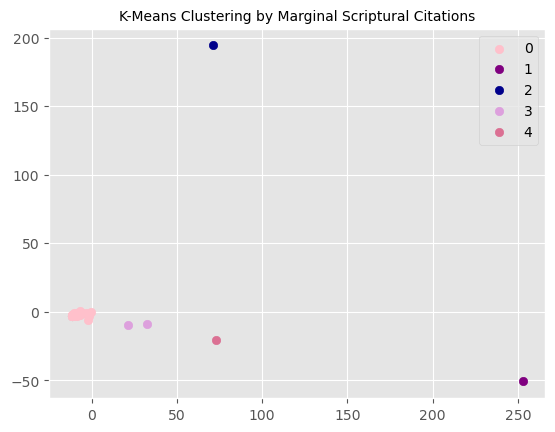

<Figure size 2000x1000 with 0 Axes>

In [3]:
cited = {}
for tcpID, c_list in all_citations.items(): 
    citations = []
    if len(c_list) == 0: 
        continue
    for passage in c_list: 
        '''Transform the citation into one unit using underscores'''
        passage = re.sub(':','_',passage)
        passage = passage.split(' ')
        passage = '_'.join(passage)
        citations.append(passage)        
        '''Extracting only the book'''
        # book = passage.split(' ')
        # if book[0] == '1' or book[0] == '2': 
        #     citations.append(f'{book[0]}_{book[1]}')
        # else: 
        #     citations.append(f'{book[0]}')
        '''Extracting only the chapter'''
        # book = passage.split(' ')
        # if book[0] == '1' or book[0] == '2': 
        #     book[2] = book[2].split(':')[0]
        #     citations.append(f'{book[0]}_{book[1]}_{book[2]}')
        # else: 
        #     book[1] = book[1].split(':')[0]
        #     citations.append(f'{book[0]}_{book[1]}')
    cited[tcpID] = ' '.join(citations)
'''Vectorization'''
vector = TfidfVectorizer(norm=None, sublinear_tf=True)
results = vector.fit_transform(cited.values())
df = pd.DataFrame(results.toarray(), index=cited.keys(), columns=vector.get_feature_names()) 
groups = pca_cluster(df,5,cited.keys(),'K-Means Clustering by Marginal Scriptural Citations')

In [11]:
for groupNum in sorted(groups.keys()):
    ids_list = groups[groupNum]
    if len(ids_list) == 1:
        print(f'There is {len(ids_list)} text in Group {groupNum}')
    else: 
        print(f'There are {len(ids_list)} texts in Group {groupNum}')
    if groupNum != 0: 
        print(f"Titles: {[f'{tcpID}: {idToTitle[tcpID]}' for tcpID in ids_list]}")
    author_id = []
    for tcpID in ids_list:
        for entry in idAuthor: 
            if tcpID in entry: 
                author_id.append(entry) 
    print(f'Group {groupNum} TCP IDs: {author_id}')
    # print(f'The locations for the texts in this cluster: {count_features(location,ids_list)}')
    # print(f'The audiences for the texts in this cluster: {count_features(audience,ids_list)}')
    # print(f'Whether or not the text mentions the provision of material help to the needy: {count_features(help_poor,ids_list)}')
    print(f'Top 20 Bigrams and Trigrams of Keywords: {count_features(ngrams,ids_list)}')
    # print(f'Top 20 Topic Words: {count_features(topics,ids_list)}')
    print(f'All subject headings: {count_features(subjects,ids_list)}')

    print(f'Most Frequent Scriptural Citations: {count_features(all_citations,ids_list,"all citations")}')
    print(f'Most Frequent Charity-Related Scriptural Citations: {count_features(charity_citations,ids_list,"charity citations")}.\n\n')

There are 48 texts in Group 0
Group 0 TCP IDs: ['Preston_A09990', 'Preston_A09963', 'Hall_A02565', 'Gouge_A85485', 'Preston_A09981', 'Preston_A10010', 'Gouge_A70130', 'Preston_A09950', 'Preston_A10024', 'Whately_A14989', 'Gataker_A01531', 'Gataker_A01530', 'Hall_A02591', 'Gataker_A01547', 'Gouge_A01970', 'Crashaw_A19588', 'Crashaw_A19589', 'Hall_A02537', 'Gataker_A01528', 'Gouge_A85486', 'Whately_A68877', 'Gouge_A85487', 'Preston_A55748', 'Gataker_A01523', 'Crashaw_A19590', 'Preston_A09999', 'Whately_A15015', 'Gataker_A01548', 'Gataker_A01534', 'Hall_A02571', 'Preston_A55754', 'Preston_A09977', 'Preston_A10030', 'Gataker_A01538', 'Hall_A86974', 'Whately_A15012', 'Gataker_A01533', 'Whately_A14996', 'Preston_A09971', 'Preston_A10027', 'Gouge_A01980', 'Preston_A10018', 'Hall_A02585', 'Preston_A09958', 'Gataker_A01524', 'Gataker_A68088', 'Preston_A09967', 'Gataker_A01553']
Top 20 Bigrams and Trigrams of Keywords: [('be_rich', 93), ('rich_man', 65), ('', 48), ('poor_man', 41), ('his_wealth'

The code below shows the TFIDF vectorization and clustering of marginal citations related to charity in the Charity Sermons Dataset

##Gataker_A72143: Certaine sermons, first preached, and after published at severall times, by M. Thomas Gataker B. of D. and pastor at Rotherhith. And now gathered together into one volume: the severall texts and titles whereof are set downe in the leafe following
- Location: St Mary's Church, Rotherhithe
- Audience: local
- Top 20 Bigrams and Trigrams of Keywords: [('rich_man', 17), ('be_rich', 11), ('worldly_wealth', 10), ('poor_man', 9), ('due_debt', 9), ('his_wealth', 8), ('rich_or_poor', 6), ('pledge_or_pawn', 6), ('love_kindness', 4), ('all_the_wealth', 4), ('we_labour', 4), ('worldly_rich', 4), ('have_bestow', 4), ('his_pawn', 4), ('industry_be', 3), ('labour_to_keep', 3), ('his_money', 3), ('great_wealth', 3), ('wealth_but', 3), ('bestow_it', 3)]
- All subject headings: []
	There are 27 marginal citations relating to charity.
- Most Frequent Charity-Related Scriptural Citations: [('2 Corinthians 9:8', 3), ('Isaiah 61:1', 2), ('Matthew 6:3', 2), ('1 John 3:17', 1), ('2 Corinthia

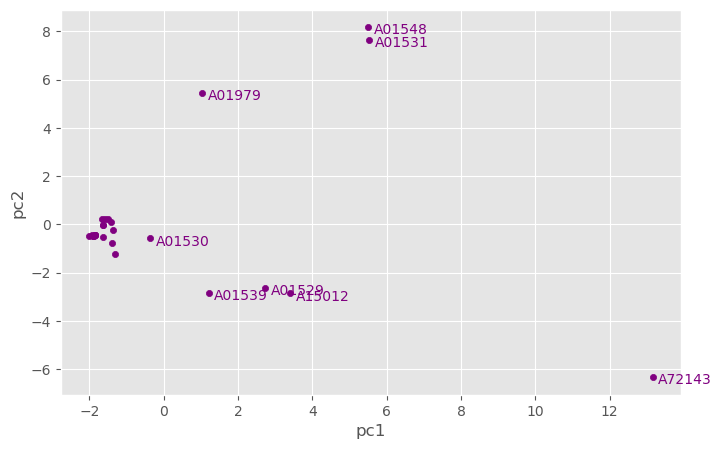

In [10]:
cited = {}
for tcpID, c_list in charity_citations.items(): 
    if len(c_list) == 0: 
        continue
    citations = []
    for passage in c_list: 
        '''Transform the citation into one unit using underscores'''
        passage = re.sub(':','_',passage)
        passage = passage.split(' ')
        passage = '_'.join(passage)
        citations.append(passage)        
    cited[tcpID] = ' '.join(citations)
'''Tfidf vectorization'''
vector = TfidfVectorizer(norm=None, sublinear_tf=True)
tfidf_results = vector.fit_transform(cited.values())
df = pd.DataFrame(tfidf_results.toarray(), index=cited.keys(), columns=vector.get_feature_names()) 

pca = PCA(n_components=2)
pca_results = pca.fit_transform(df) 
pca_df = pd.DataFrame(pca_results, index=list(df.index), columns=["pc1","pc2"])

ax = pca_df.plot(x='pc1',y='pc2',kind="scatter",figsize=(8, 5),s=20,c='purple')
for txt in pca_df.index:
    if txt in ['A15012', 'A72143', 'A01531', 'A01548','A01979','A01529','A01539','A01530']:
        x = pca_df.pc1.loc[txt]
        y = pca_df.pc2.loc[txt]
        ax.annotate(txt, (x,y),fontsize=10,
                xytext=(4,-5),textcoords='offset points',
                family='sans-serif', color='purple')
        for entry in idAuthor:
            if txt in entry: 
                author_id = entry
                break
        print(f'##{author_id}: {idToTitle[txt]}')
        print(f'- Location: {location[txt][0]}')
        print(f'- Audience: {audience[txt][0]}')
        print(f'- Top 20 Bigrams and Trigrams of Keywords: {count_features(ngrams,[txt])}')
        print(f'- All subject headings: {count_features(subjects,[txt])}')
        print(f'- Most Frequent Charity-Related Scriptural Citations: {count_features(charity_citations,[txt],"charity citations")}.\n\n')

Vectorization and clustering of the context windows (20 words before and after) around key terms

In [16]:
tcpIDs = [_ for _ in tcpIDs if len(charity_citations[_])>0]
contexts = getTexts('/Users/amycweng/Digital Humanities/charityContexts',tcpIDs)
vector = TfidfVectorizer(norm=None, sublinear_tf=True)
tfidf_results = vector.fit_transform(contexts.values())
df = pd.DataFrame(tfidf_results.toarray(), index=contexts.keys(), columns=vector.get_feature_names()) 

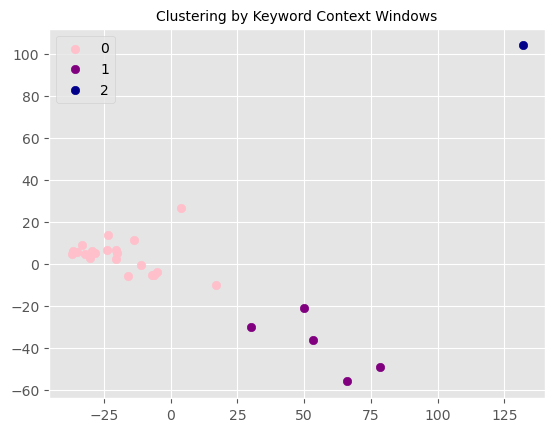

<Figure size 2000x1000 with 0 Axes>

In [17]:
groups = pca_cluster(df,3,tcpIDs,'Clustering by Keyword Context Windows')

In [18]:
for groupNum, ids_list in groups.items(): 
    author_id = []
    for tcpID in ids_list:
        for entry in idAuthor: 
            if tcpID in entry: 
                author_id.append(entry)
    if len(ids_list) == 1:
        print(f'There is {len(ids_list)} text in Group {groupNum}')
    else: 
        print(f'There are {len(ids_list)} texts in Group {groupNum}')
    # if groupNum != 1: 
    #     print(f'Titles: {find_titles(ids_list,idToTitle)}')
    print(f'Group {groupNum+1} TCP IDs: {author_id}')
    print(f'\tThe locations for the texts in this cluster: {count_features(location,ids_list)}')
    print(f'\tThe audiences for the texts in this cluster: {count_features(audience,ids_list)}')
    print(f'\tWhether or not the text mentions the provision of material help to the needy: {count_features(help_poor,ids_list)}')

    print(f'\tTop 20 Bigrams and Trigrams of Keywords: {count_features(ngrams,ids_list)}')
    print(f'\tTop 20 Topic Words: {count_features(topics,ids_list)}')
    print(f'\tAll subject headings: {count_features(subjects,ids_list)}')

    print(f'\tMost Frequent Scriptural Citations: {count_features(all_citations,ids_list,"all citations")}')
    print(f'\tMost Frequent Charity-Related Scriptural Citations: {count_features(charity_citations,ids_list,"charity citations")}.\n\n')

There is 1 text in Group 2
Group 3 TCP IDs: ['Gataker_A68088']
	The locations for the texts in this cluster: [('London', 1)]
	The audiences for the texts in this cluster: [('funeral', 1)]
	Whether or not the text mentions the provision of material help to the needy: [(True, 1)]
	Top 20 Bigrams and Trigrams of Keywords: [('earnest_penny', 2), ('as_a_beggar', 1), ('rich_man', 1), ('our_labour', 1), ('their_labour', 1), ('continual_labour', 1), ('world_wealth', 1), ('world_in_exchange', 1), ('wealth_of_this', 1), ('labour_to_keep', 1), ('labour_then', 1), ('yes_labour', 1), ('labour_to_work', 1)]
	Top 20 Topic Words: [('death', 1), ('god', 1), ('life', 1), ('desire', 1), ('christ', 1), ('love', 1), ('good', 1), ('cause', 1), ('yes', 1), ('die', 1)]
	All subject headings: [('Crisp, Rebekka.', 1), ('Funeral sermons.', 1)]
	There are 383 marginal citations in total.
	Most Frequent Scriptural Citations: [('2 Corinthians 5:8', 7), ('Revelation 14:13', 5), ('2 Corinthians 5:4', 4), ('Romans 7:2